### BertTopic: Topic Modeling of Publicly Available Tweets Classified as Misinformation

* This code has been adapted from [here](https://maartengr.github.io/BERTopic/algorithm/algorithm.html#code-overview) .
* See Readme file to identify the list of tweet IDs used for this task.

In [1]:
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
import pandas as pd

import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all" 
pd.set_option('display.max_colwidth', None) #shows full text 

from nltk import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import matplotlib.pyplot as plt
import re
import string #to clean punctuation for coherence/diversity measures

2023-03-20 17:10:19.473770: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-20 17:10:19.473818: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to /home/jupyter-
[nltk_data]     rly0/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter-
[nltk_data]     rly0/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter-
[nltk_data]     rly0/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jupyter-
[nltk_data]     rly0/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [89]:
df = pd.read_csv("hayawi_final.csv")

#### Select Relevant Columns and Rows Labeled as Misinformation

In [90]:
df_relev = df[["full_text", "created_at", "is_misinfo", "id"]]
df_relev_misinfo = df_relev[df_relev["is_misinfo"] == 1]
df_relev_misinfo.shape

(3911, 4)

#### Basic Pre-processing

* drop tweets with the same text (duplicates)
* remove urls
* additional preprocessing (e.g., remove "\n")

In [91]:
df_relev_misinfo.dropna(subset=['full_text'], inplace=True) #drop na
df_relev_misinfo = pd.DataFrame(df_relev_misinfo.drop_duplicates(subset=['full_text'])) #drop duplicates
df_relev_misinfo.shape

(3829, 4)

In [92]:
def clean_tweet(text): #substitute some words; remove hyperlinks
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    for r in (("covid-19","covid"), ("covid19","covid"), ("\n",""), ("&","and")):
        text = text.replace(*r)
    return text

In [93]:
df_relev_misinfo.loc[:, "full_text"] = df_relev_misinfo.loc[:, "full_text"].apply(clean_tweet) #run function for each tweet
df_relev_misinfo.head(1)

,full_text,created_at,is_misinfo,id
3,"a new strain, more contagious....yet the same rushed vaccine will save you. hurry up and get in line for your shot!!!",Thu Dec 31 16:59:27 +0000 2020,1,1344689636615073793


Transform tweets to a list of tweets:

In [94]:
df_relev_misinfo['totalwords'] = df_relev_misinfo['full_text'].str.split().str.len()
col_list = df_relev_misinfo.full_text.values.tolist()
docs = col_list
len(docs)

3829

#### Visually explore the length of tweets

Text(0.5, 0, 'Length of Text')

Text(0, 0.5, 'Frequency')

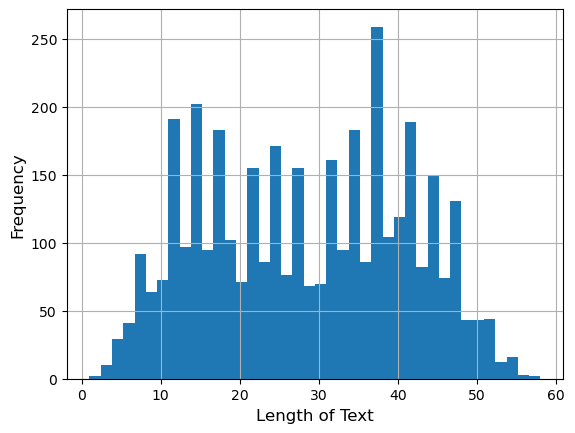

In [95]:
text_length_plot = df_relev_misinfo["totalwords"].hist(bins=40)
plt.xlabel('Length of Text', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.tick_params(labelsize = 10)
plt.show()

### Perform Topic Modeling

In [96]:
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2") # #up to 256 tokens; default model for Bertopic

# Step 2 - Reduce dimensionality using UMAP
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics and lemmatize terms (this will happen after clusering)
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
stopwords = nltk.corpus.stopwords.words('english')
vectorizer_model = CountVectorizer(lowercase=True, stop_words=stopwords,tokenizer=LemmaTokenizer(),  ngram_range=(1, 1))

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - (Optional) Fine-tune topic representations with a `bertopic.representation` model
representation_model = KeyBERTInspired(top_n_words=50, random_state=40)

In [97]:
topic_model = BERTopic(nr_topics=8,
                       embedding_model=embedding_model,          # Step 1 - Extract embeddings
                       umap_model=umap_model,                    # Step 2 - Reduce dimensionality
                       hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
                       vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
                       ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
                       representation_model=representation_model,# Step 6 - Fine-tune topic represenations
                       calculate_probabilities=False,            # Calculates probabilities for each topic for a specific doc;takes time
                       top_n_words=50,                           # Shows top N words in the outputs
                       min_topic_size=20)                        # Specify min size of docs in the cluster

topics, probs = topic_model.fit_transform(docs) #fits the model & predicts documents

### Get Summary of the Model and its Parameters

In [98]:
topic_model.get_params()

{'calculate_probabilities': False,
 'ctfidf_model': ClassTfidfTransformer(),
 'embedding_model': <bertopic.backend._sentencetransformers.SentenceTransformerBackend at 0x7fe038bcf3a0>,
 'hdbscan_model': HDBSCAN(min_cluster_size=20, prediction_data=True),
 'language': None,
 'low_memory': False,
 'min_topic_size': 20,
 'n_gram_range': (1, 1),
 'nr_topics': 8,
 'representation_model': KeyBERTInspired(random_state=40, top_n_words=50),
 'seed_topic_list': None,
 'top_n_words': 50,
 'umap_model': UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=5, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}),
 'vectorizer_model': CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                             'ourselves', 'you', "you're", "you've", "you'll",
                             "you'd", 'your', 'yours', 'yourself', 'yourselves',
                             '

### Get Topic Frequencies
* **Note:** "-1" is not a topic but a collection of tweets that have not been assigned to any topic

In [104]:
topic_model.get_topic_freq()

,Topic,Count
0,-1,1857
1,0,1516
2,1,113
3,2,96
4,3,87
5,4,59
6,5,51
7,6,50


#### Calculate Topic Coherence Score

In [105]:
documents = pd.DataFrame({"Document": docs,
                          "ID": range(len(docs)),
                          "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]

topic_words = [[words for words, _ in topic_model.get_topic(topic) if words!=''] 
               for topic in range(len(set(topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
topic_coherence = coherence_model.get_coherence()

In [106]:
print(f"Topic coherence score for this model is {topic_coherence}.")

Topic coherence score for this model is 0.30226207918703596.


#### Calculate Topic Diversity Score

* Topic diversity ranges from 0 to 1 with **higher** values indicating more varied topics (a higher value is better)
* Need to put data in the requerwd format: list of the lists; example: res = [['dog', 'cat', 'chicken'], ['blue', 'green', 'white']]
* Neet to remove topic -1 for measuring coherence (technically, this is not a topic)

In [107]:
results=topic_model.get_topics()

res = [] #initiate empty list of the lists
for topic, words in results.items():
    if topic != -1:
        res_temp = []
        for word, value in words:
            res_temp.append(word)
        res.append(res_temp)
    

punctuation = list(string.punctuation)
punctuation.append("’")
res = [[element for element in sublist if element not in punctuation] for sublist in res] #remove tokens that are punctuation only

In [108]:
def proportion_unique_words(topics, topk):
    """
    compute the proportion of unique words
    Parameters:
    topics: a list of lists of words
    topk: top k words on which the topic diversity will be computed
    """
    if topk > len(topics[0]):
        raise Exception('Words in topics are less than '+str(topk)) #???????
    else:
        unique_words = set()
        for topic in topics:
            unique_words = unique_words.union(set(topic[:topk])) #create a set of unique words accross all topics based on topk parameter for each topic
        puw = len(unique_words) / (topk * len(topics)) #percentage of unique words divided by total N of top words accross all topics (e.g., top 10 words x 5 topics = 50 words)
        return puw

topic_diversity = proportion_unique_words(res, topk=20)
print(f"Topic diversity score for this model is {topic_diversity}.")

Topic diversity score for this model is 0.8214285714285714.


### Vizualize Most Representative Words

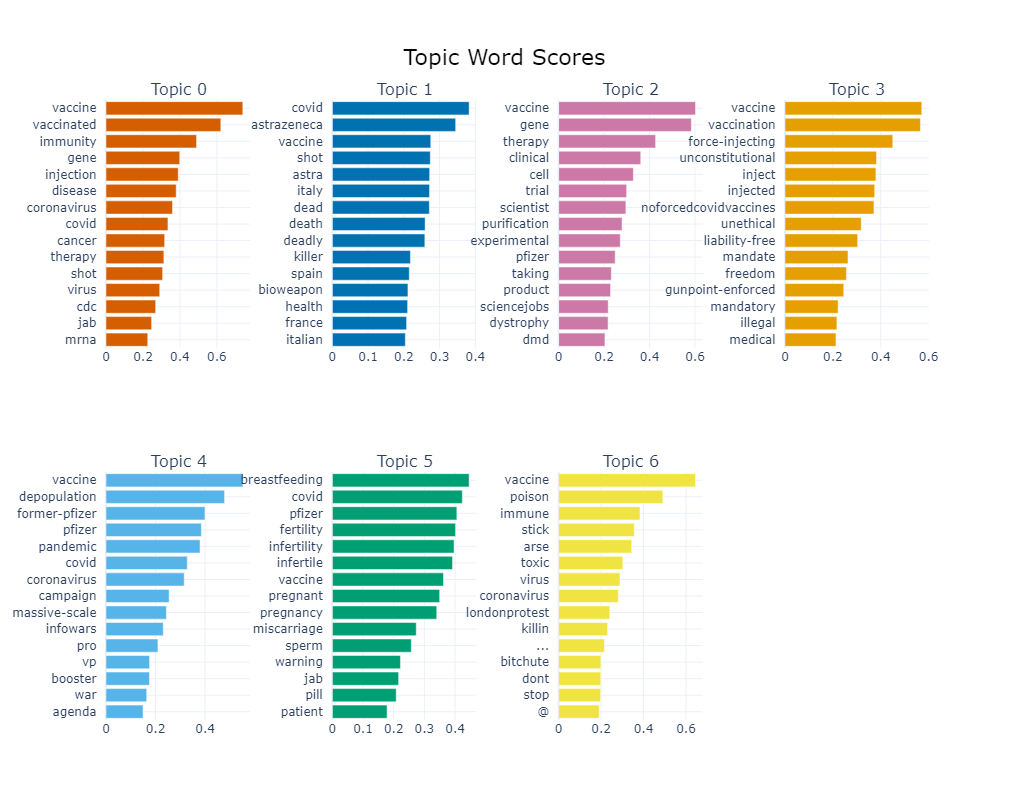

In [109]:
topic_model.visualize_barchart(n_words=15, width = 250, height = 400, top_n_topics=25)

#### Create a DataFrame with Top Words for Each Topic

In [111]:
results=topic_model.get_topics()
ds = []
for top, words in results.items():
    for word, value in words:
        d = {}
        d['topic'] = top
        d['word'] = word
        d['value'] = value
        ds.append(d)

top_words_df = pd.DataFrame(ds)
top_words_df.head(5)
#top_words_df.to_csv("top_words_per_topic_Twitter.csv")

,topic,word,value
0,-1,vaccine,0.759811
1,-1,vaccination,0.684207
2,-1,covid,0.502629
3,-1,injection,0.413837
4,-1,fda,0.375735


### Vizualize Distances for All Topics

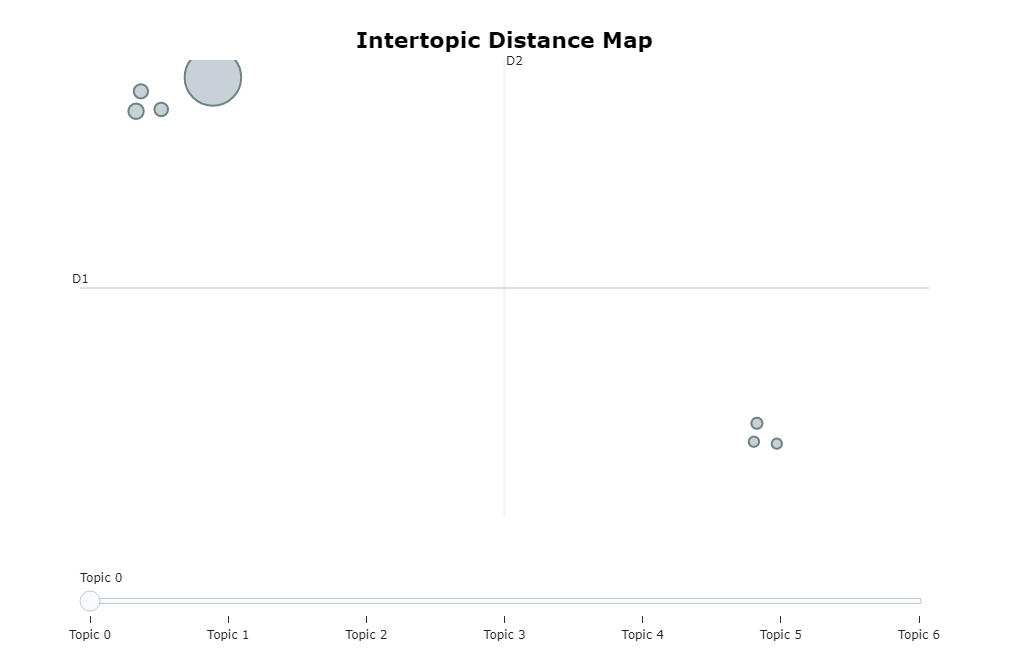

In [112]:
topic_model.visualize_topics()

#### Vizualize Topic Hierarchy

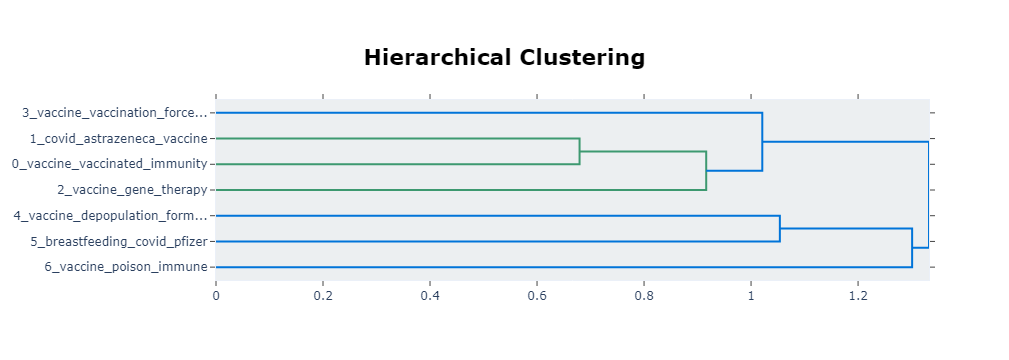

In [122]:
topic_model.visualize_hierarchy()

### Print the Most Representative Documents

In [123]:
topic_model.get_representative_docs(topic = 2)

['gene therapy... not vaccine. ',
 'vaccine or experimental gene therapy?',
 'experimental gene therapy.  ']

### Find Salient Topics with the Potentially Relevent Words

In [125]:
topic_model.find_topics("infertility")

([5, -1, 2, 0, 3], [0.6565989, 0.38813442, 0.3875344, 0.38416392, 0.36910117])

#### Add IDs to Document-Probability File

In [117]:
all_docs_allCols = topic_model.get_document_info(docs)
all_docs_relCols1 = all_docs_allCols[["Document", "Topic", "Probability"]]
all_docs_relCols2 = df_relev_misinfo[["created_at", "id"]]
merged_df = pd.merge(all_docs_relCols1, all_docs_relCols2, left_index=True, right_index=True)

#### Save Comments Grouped By Topics in CSV File 

In [126]:
sorted_df = merged_df.groupby('Topic').apply(lambda x: x.sort_values('Probability', ascending=False))
sorted_df.reset_index(drop=True, inplace=True)
sorted_df.to_csv("TopsDocs_Twitter.csv")